In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import utils


In [2]:
import sys
sys.executable

'/opt/conda/bin/python'

In [3]:
model = 'gemini'
locale = 'us'

In [4]:
ESCI_DATASET_ROOT = '/usr/local/google/home/raulramos/projects/esci-data'

dgt = utils.load_examples(ESCI_DATASET_ROOT=ESCI_DATASET_ROOT, locale=locale)

In [7]:
print (utils.get_product_string(dgt.iloc[1]))

<TITLE>Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM</TITLE>
<BULLETS>OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at 80 CFM which means it’s able to manage spaces up to 80 square feet and is very quiet..
BATH FANS HELPS REMOVE HARSH ODOR: When cleaning the bathroom or toilet, harsh chemicals are used and they can leave an obnoxious odor behind. Homewerk’s bathroom fans can help remove this odor with its powerful ventilation
BUILD QUALITY: Designed to be corrosion resistant with its galvanized steel construction featuring a modern style round shape and has an 4000K Cool White Light LED Light. AC motor.
EASY INSTALLATION: This exhaust bath fan is easy to install with its no-cut design and ceiling mount ventilation. Ceiling Opening (L) 7-1/2 in x Ceiling Opening (W) 7-1/4 x Ceiling Opening (H) 5-3/4 in. 13

In [3]:
q = pd.read_parquet(f'{model}/queries-{locale}.parquet')

In [4]:
p = pd.read_parquet(f'{model}/products-{locale}.parquet')

In [5]:
q.shape, p.shape

((97345, 2), (1215851, 2))

In [6]:
qe = np.stack(q.embeddings.values)
pe = np.stack(p.embeddings.values)
qe.shape, pe.shape

((97345, 768), (1215851, 768))

In [8]:
def get_dotp_closests_idxs(q_embedding,p_embeddings_matrix, topk=40):
    return np.argsort( p_embeddings_matrix.dot(q_embedding) )[-topk:][::-1]


## select random query

In [82]:
qid = np.random.choice(q.index)
q.loc[qid]

query                                        case for galaxy s8
embeddings    [0.003485163, -0.032386877, -0.016055238, -0.0...
Name: 23535, dtype: object

In [83]:
qgt = dgt[dgt.query_id == qid].copy()
qgt['dotp_distance'] = np.stack(p.loc[qgt.product_id].embeddings).dot(q.loc[qid].embeddings)

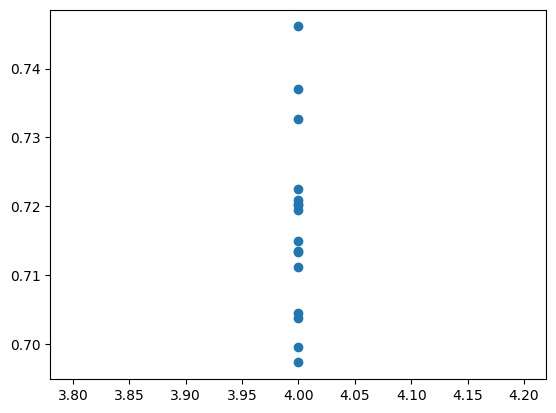

In [84]:
plt.scatter(qgt.relevance, qgt.dotp_distance)

## get closest product embeddings

In [85]:
p_relevant = p.iloc[get_dotp_closests_idxs(q.loc[qid].embeddings, pe)].copy()
p_relevant['dotp_similarity'] = np.stack(p_relevant.embeddings).dot(q.loc[qid].embeddings)

In [86]:
pi.name

'B07TZGTFVF'

In [87]:
'B00SGBM92C' in qgt.product_id.values

False

In [88]:
print (f'query: {q.loc[qid].query}')
print ('\n------ text embeddings ranking (* indicates it is ground truth relevant)')
for i in range(len(p_relevant)):
    pi = p_relevant.iloc[i]
    print (f"{i:2d} {pi.name:10s} {'*' if pi.name in qgt.product_id.values else ' '} {pi.dotp_similarity:.4f} {pi['product'][:60].replace('\n',' ')\
                                                                                                           .replace('<TITLE>','')\
                                                                                                           .replace('</TITLE>','')}")
print ('\n------ ground truth relevant')
for _, gi in qgt[qgt.relevance==4].sort_values(by='dotp_distance', ascending=False).iloc[:10].iterrows():
    print (f'{gi.product_id} {gi.dotp_distance:.4f} {gi.product_title[:60]}')
    


query: case for galaxy s8

------ text embeddings ranking (* indicates it is ground truth relevant)
 0 B071YCHP8P   0.7662 BodyGuardz - Shock Case for Samsung Galaxy S8, TPU Ca
 1 B07LD21GPH   0.7504 Hocase Galaxy S8 Case, Heavy Duty Protection Shock Ab
 2 B072LLQWGF   0.7466 S8 Case, Galaxy S8 Case, iYCK Premium PU Leather Embo
 3 B06XCT3FYJ * 0.7461 OTTERBOX Commuter Series for Samsung Galaxy S8 - Frus
 4 B07792648P   0.7432 SUPCASE Full-Body Rugged Holster Case for Samsung Gal
 5 B06XCSC1F4   0.7424 Otterbox Commuter Series for Samsung Galaxy s8 - Reta
 6 B07DPDMVH6   0.7421 Hocase Galaxy S8 Case, Heavy Duty Shockproof Protecti
 7 B071YCQ32X   0.7421 BodyGuardz Shock Case For Samsung Galaxy S8+ (ONLY) -
 8 B06XY789RP   0.7419 ProCase Galaxy S8 Wallet Case, Flip Kickstand Case wi
 9 B07W765C93   0.7415 Samsung Galaxy S8 Case,Samsung Galaxy S8 Wallet Case 
10 B06XD3W3WK   0.7413 OTTERBOX COMMUTER SERIES for Samsung Galaxy S8 - Frus
11 B07QST39D8   0.7391 JETech Shockproof Case for Sam

## show details of the top 3

In [20]:
print ('query:', q.loc[qid].query)

query: gravacion laser


In [25]:
for i in range(3):
    pi = p_relevant.iloc[i]
    print ('top', i+1, ':', pi.name)
    print (pi['product'])
    print ('---------')
    

top 1 : B0012M9HOA
<TITLE>Laser 2459 - Llave inglesa (100 mm)</TITLE>
<BULLETS>Marca láser</BULLETS>
<BRAND>Laser</BRAND>
---------
top 2 : B08TC354DX
<TITLE>Máquina de grabado láser de 1,6 W con soporte de enfoque automático, cortadora láser láser láser láser con funda plegable y soporte eléctrico automático</TITLE>
<DESCRIPTION><p>Especificaciones: </p><p>Tamaño base: 65 x 61 x 53 mm. </p><p>Tamaño del traje: 23 x 19 x 18,5 cm. </p><p>Peso: 190 g. </p><p>Peso del paquete: 2,4 kg. </p><p>Fuente de láser: 1500 MW 405 nm. Láser azul-violetter </p><p>Salida láser: 100 niveles ajustables. </p><p>Material: aluminio anodizado. </p><p>Color: gris. </p><p>Conexión de la aplicación: Bluetooth. </p><p>Formatos de archivo compatibles: JPG / BMP / PNG / G-Code </p><p>Compatible: iOS 10.0 + / Android 4.4 + </p><p>Windows 7/8/10/Vista / XP, Mac OS-10.10/11/12/13/14. </p><p>Conector de comunicación: Tipo C (5 V, 2 A) </p><p>Rango de temperatura de funcionamiento en Celsius: 0 65 – 65 ℃. </p><p>Rango

## show details of the bottom 3

In [26]:
for i in [-3,-2,-1]:
    pi = p_relevant.iloc[i]
    print ('bottom', i, ':', pi.name)
    print (pi['product'])
    print ('---------')
    

bottom -3 : B09G9C3BV2
<TITLE>Máquina de grabado láser, cortadora láser función de enfoque de diseño de protección para los ojos, grabadora láser DIY CNC para metal, madera, cuero, vinilo (A5 Pro 40W)</TITLE>
<DESCRIPTION><p>Especificaciones: </p><p>Modelo: ATOMSTACK A5 PRO 40W. </p><p>Tamaño: 410 x 400 mm. </p><p>Material de tallado: madera, bambú, cartón, plástico, cuero, placa de circuito, óxido de aluminio, revestimiento antirreflectante y metal lacado, cuchillo universal ennegrecido. </p><p>Material de corte: cartón, fieltro, chapa, acrílico, algunas placas de plástico delgadas. </p><p>Potencia del láser: 40 W. </p><p>Potencia óptica del láser: 5-5,5 W. </p><p>Longitud de onda láser: 455 ± 5 nm. </p><p>Precisión de grabado: 0,01 mm. </p><p>Método de enfoque: láser de enfoque fijo, enfoque libre. </p><p>Software operativo: LaserGRBL, LightBurn, compatible con Win XP / Win 7 / Win 8 / XP / Win 10. </p><p>Formatos de archivo compatibles: NC, BMP, JPG, PNG, DXF </p><p>Método de transf